### Importación de librerías

In [19]:
import pandas as pd
import numpy as np
import os
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Carga y verificación de datos

In [20]:
file_path = r"C:\Users\Danie\OneDrive\Escritorio\Workshop03\data\merged.csv"

try:
    df = pd.read_csv(file_path)
    print("Archivo cargado correctamente.")
except FileNotFoundError:
    print(f"Error: El archivo no se encontró en la ruta: {file_path}")
    exit()
except Exception as e:
    print(f"Error al leer el archivo CSV: {e}")
    exit()

Archivo cargado correctamente.


### Features y expansión polinómica

In [21]:
# Nuevas características
df["gdp_life_combo"] = df["gdp_per_capita"] * df["life_expectancy"]
df["support_per_gdp"] = df["social_support"] / (df["gdp_per_capita"] + 1e-5)

# Expansión polinómica
features_original = ["gdp_per_capita", "social_support", "life_expectancy"]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df[features_original])
poly_feature_names = poly.get_feature_names_out(features_original)
df_poly = pd.DataFrame(X_poly, columns=poly_feature_names)



### División y escalado

In [22]:
# Evitar columnas duplicadas y mantener el orden
df_extended = pd.concat([df, df_poly], axis=1)

features_extended = list(dict.fromkeys(
    [col for col in df_extended.columns if col not in ["happiness_score", "country"]]
))
target = "happiness_score"

X = df_extended[features_extended]
y = df_extended[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Modelos a evaluar

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=400, learning_rate=0.015, max_depth=4, subsample=0.8, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=400, learning_rate=0.025, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
}

### Evaluación de modelos

In [24]:
results = {}
for name, model in models.items():
    print(f"\nEntrenando y evaluando: {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }


Entrenando y evaluando: Linear Regression

Entrenando y evaluando: Ridge Regression

Entrenando y evaluando: Gradient Boosting

Entrenando y evaluando: XGBoost


### Modelo de Stacking y entrenamiento

In [25]:
param_grid_meta = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.02],
    'max_depth': [3, 4]
}
grid_search_meta = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_meta,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
stacking_model = StackingRegressor(
    estimators=[
        ('lr', models["Linear Regression"]),
        ('ridge', models["Ridge Regression"]),
        ('gb', models["Gradient Boosting"]),
        ('xgb', models["XGBoost"])
    ],
    final_estimator=grid_search_meta,
    cv=5
)

print("\nEntrenando modelo de stacking...")
stacking_model.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_model.predict(X_test_scaled)
results["Stacking Model"] = {
    "MSE": mean_squared_error(y_test, y_pred_stacking),
    "MAE": mean_absolute_error(y_test, y_pred_stacking),
    "R2": r2_score(y_test, y_pred_stacking)
}

print("\nComparativa de modelos:")
results_df = pd.DataFrame(results).T.sort_values(by="R2", ascending=False)
print(results_df)



Entrenando modelo de stacking...

Comparativa de modelos:
                        MSE       MAE        R2
XGBoost            0.213411  0.360463  0.824552
Gradient Boosting  0.225452  0.369393  0.814653
Stacking Model     0.242858  0.387902  0.800344
Linear Regression  0.296260  0.425508  0.756441
Ridge Regression   0.297791  0.427456  0.755182


### Guardar el modelo entrenado

In [26]:
best_model_name = results_df.index[0]
best_model = stacking_model if best_model_name == "Stacking Model" else models[best_model_name]

joblib.dump(best_model, os.path.join(model_dir, f"{best_model_name.lower().replace(' ', '_')}.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))
joblib.dump(poly, os.path.join(model_dir, "poly_features.pkl"))
joblib.dump(features_extended, os.path.join(model_dir, "features_extended.pkl"))

print(f"\nModelo guardado: {best_model_name}")
print("Todos los modelos, etc se han almacenado correctamente en la carpeta 'models'.")


Modelo guardado: XGBoost
Todos los modelos, etc se han almacenado correctamente en la carpeta 'models'.


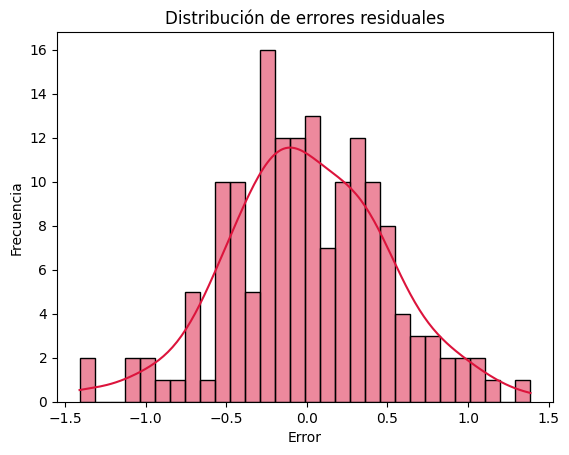

In [27]:
residuals = y_test - y_pred_stacking
sns.histplot(residuals, bins=30, kde=True, color="crimson")
plt.title("Distribución de errores residuales")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.show()


## Impacto de las variables

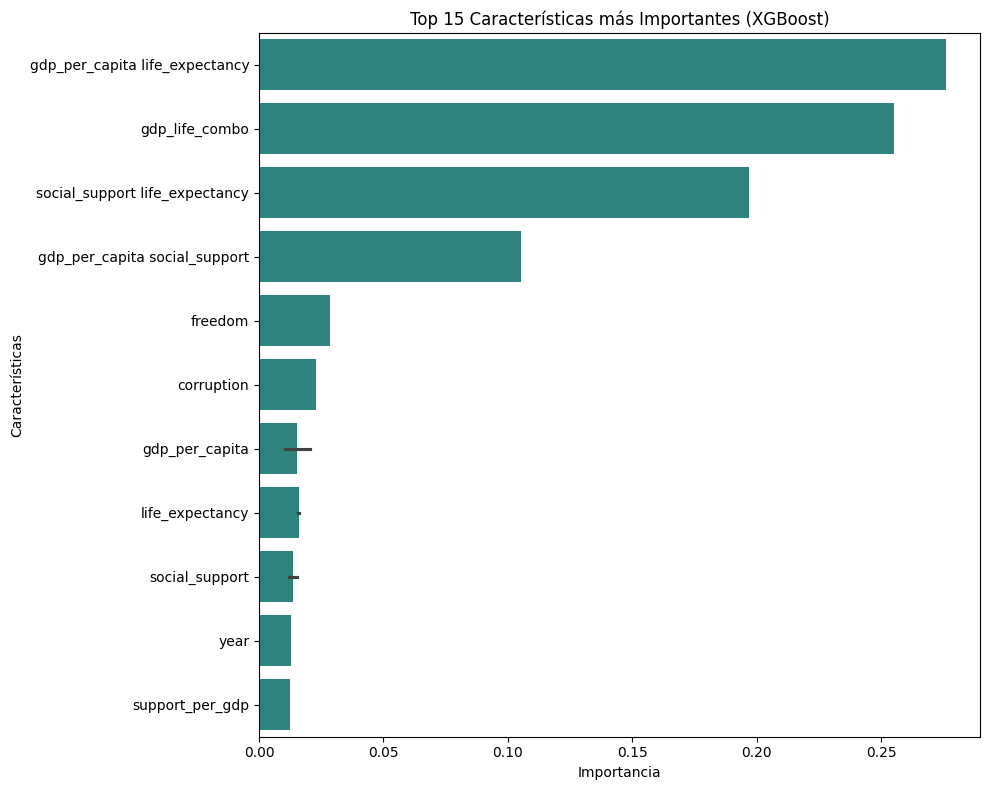

In [28]:
xgb_model = models["XGBoost"]
importances_xgb = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

top_n = 15
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, color=sns.color_palette("viridis", 1)[0])
plt.title(f'Top {top_n} Características más Importantes (XGBoost)')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

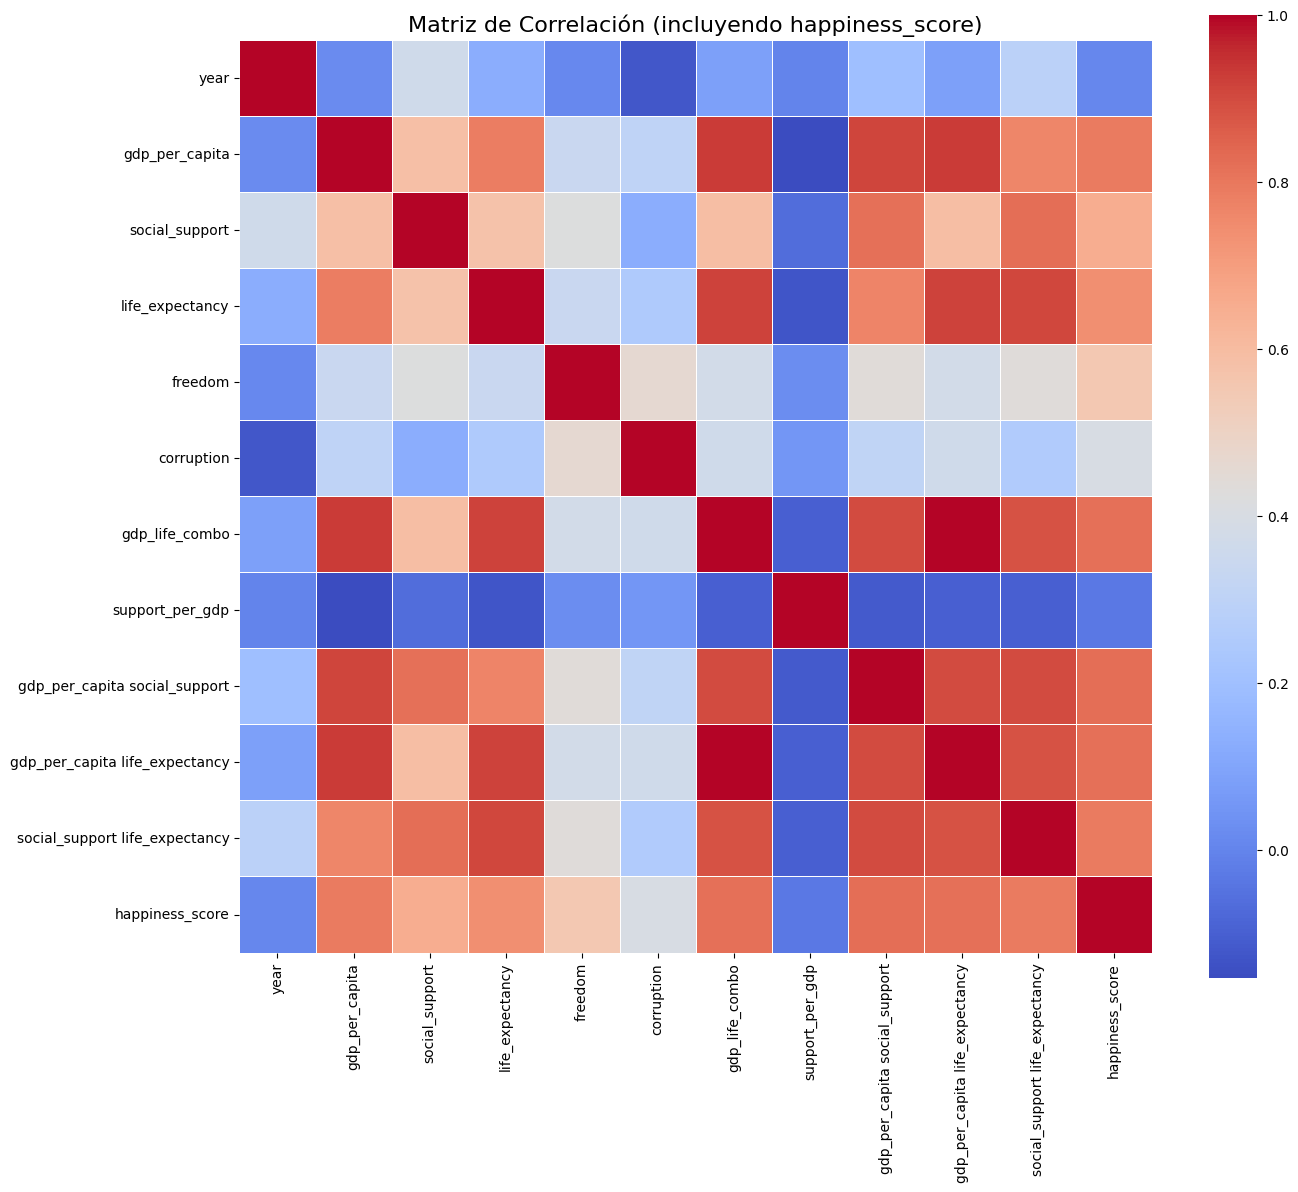

In [29]:
# Combinar features con el target
selected_columns = features_extended + ["happiness_score"]

# Extraer solo columnas únicas y numéricas
corr_data = df_extended[selected_columns]
corr_data = corr_data.loc[:, ~corr_data.columns.duplicated()]  # Eliminar columnas duplicadas
corr_data = corr_data.select_dtypes(include=[np.number])        # Solo numéricas

# Calcular matriz de correlación
corr_matrix = corr_data.corr()

# Visualización
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", square=True, linewidths=0.5)
plt.title("Matriz de Correlación (incluyendo happiness_score)", fontsize=16)
plt.tight_layout()
plt.show()


# Conclusiones

## 1. Desempeño del mejor modelo (XGBoost)

- R² (score): `0.8216` → El modelo explica aproximadamente el 82,16% de la varianza en el `happiness_score`, lo cual indica una alta capacidad predictiva.

- MAE: `0.3674` y MSE: `0.2169` → Errores bajos que indican buena capacidad predictiva.

## 2. Evaluación del error en contexto

- MAE: 0.3674 → Error absoluto medio bajo.

- MAE relativo (% sobre el valor medio real): 6,82%
El modelo comete un error promedio del 6,82% respecto al valor medio de `happiness_score`. Esto indica un buen desempeño en términos absolutos.

- MAPE (Error porcentual absoluto medio): 7.29%
En promedio, cada predicción se desvía un 7.29% del valor real. Este valor es bajo, lo que sugiere que el modelo es consistente y preciso en general.

- Varianza explicada R²: 82,16%
El modelo logra explicar aproximadamente el 82% de la variabilidad en los datos. Esto significa que tiene una alta capacidad predictiva, aunque aún hay un 18% de variación no explicada (posiblemente por ruido o variables no incluidas).

## 3. Errores residuales

- El gráfico de distribución de errores residuales muestra:

- Distribución simétrica y centrada en 0, similar a una normal.

- No se observan errores extremos ni asimetrías severas.

- Esto valida que el modelo no presenta sesgo sistemático y generaliza bien en los datos de prueba.

## 4. Importancia de las variables (features)

- Entre las 15 variables más importantes, destacan:

- `gdp_per_capita * freedom`, `social_support * life_expectancy`, `gdp_life_combo`, `gdp_per_capita * life_expectancy`.

- Las variables derivadas y polinómicas aportaron mucho valor, indicando que las interacciones entre economía, libertad, salud y apoyo social son determinantes en el `happiness_score`.

- El uso de `PolynomialFeatures` y variables cruzadas fue una decisión acertada en el feature engineering.

## 5. Matriz de correlación

- Se confirma una fuerte correlación positiva de:

- `gdp_per_capita`, `life_expectancy`, `social_support` con `happiness_score`.

- Algunas interacciones (`freedom_corr`, `support_per_gdp`) también están moderadamente relacionadas.

- El análisis presenta que la riqueza por habitante y la salud tienen un peso clave, aunque el componente subjetivo como la libertad también tiene correlación con la percepción de felicidad.